<a href="https://colab.research.google.com/github/lukemckinstry/fastai-projects/blob/master/ships_tanz_mount_gdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation on aeriel ship images - based on CamVid example


In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
DATA_DIR = root_dir + 'Colab Notebooks/ships/'
#os.listdir(root_dir + 'Colab Notebooks/ships')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path_lbl = DATA_DIR + 'label'
path_img = DATA_DIR + 'Train'
path_test = DATA_DIR + 'test'

In [0]:
Path(path_lbl).mkdir(exist_ok=True, parents=True)
Path(path_img).mkdir(exist_ok=True, parents=True)
Path(path_test).mkdir(exist_ok=True, parents=True)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
#according to error
os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [5]:
print( gpu_mem_get() )

GPUMemory(total=11441, free=11430, used=11)


### create folders and download data

In [0]:
import zipfile
with zipfile.ZipFile( DATA_DIR + 'ships_mini.zip' ,"r") as zip_ref:
    zip_ref.extractall( path_img )

In [0]:
with zipfile.ZipFile( DATA_DIR + 'test_ships_mini.zip' ,"r") as zip_ref:
    zip_ref.extractall( path_test )

In [0]:
#os.listdir(root_dir + 'Colab Notebooks/ships')

os.listdir( path_img )

In [0]:
label_df_raw = pd.read_csv(DATA_DIR + 'train_ship_segmentations_v2.csv', low_memory=False )
label_df_raw = label_df_raw.replace(np.nan, '', regex=True)

In [0]:
pd.set_option("display.max_colwidth", 10000)

## Move some ship files to valid.txt 


In [0]:
#ship_files = os.listdir( '/home/ubuntu/data/ships_med/train' )
ship_files = os.listdir( path_img )

In [9]:
len(ship_files)
ship_files[:30]

['00003e153.jpg',
 '0001124c7.jpg',
 '000155de5.jpg',
 '000194a2d.jpg',
 '0001b1832.jpg',
 '00021ddc3.jpg',
 '0002d0f32.jpg',
 '000303d4d.jpg',
 '000532683.jpg',
 '00053c6ba.jpg',
 '00057a50d.jpg',
 '000592296.jpg',
 '0005d01c8.jpg',
 '0005d6d95.jpg',
 '0006c52e8.jpg',
 '0007b8229.jpg',
 '000805313.jpg',
 '000811bb6.jpg',
 '0008d6216.jpg',
 '000913daf.jpg',
 '000952d51.jpg',
 '000969125.jpg',
 '0009a46e1.jpg',
 '000a4d4fd.jpg',
 '000aed819.jpg',
 '000baef0c.jpg',
 '000bd9ac4.jpg',
 '000c150b0.jpg',
 '000c34352.jpg',
 '000d26c17.jpg']

In [0]:
valid_ships = ship_files[:30]

In [0]:
with open(str(DATA_DIR) + '/valid.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(valid_ships))

In [12]:
os.listdir( DATA_DIR )
DATA_DIR
!cat /content/gdrive/'My Drive'/'Colab Notebooks'/ships/valid.txt | wc -l

29


### make dataframe of rle data for masks

In [13]:
#ship_files = os.listdir('data/ships_mini/Train')
def in_mini(f):
  return f['ImageId'] in ship_files
masks = label_df_raw[label_df_raw.apply(in_mini, axis=1)]
masks.shape, label_df_raw.shape



((582, 2), (231723, 2))

In [14]:
#merge mask df on image id
masks = masks.groupby('ImageId')['EncodedPixels'].apply(lambda x: ' '.join(x)).reset_index()
masks.shape

(496, 2)

## Write masks to jpgs in /labels

In [0]:

dmasks = masks.to_dict()
#for r in range(2,5):

for r in range(len( dmasks['ImageId'])):
    try:
        image_id = dmasks['ImageId'][r]
        filename = str( DATA_DIR + 'label/') + image_id
        rle_0 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels'].to_string(index=False)
        rle_mask = open_mask_rle( rle_0, [768,768])
        rle_mask = rle_mask.rotate(-90).flip_lr() 
        rle_mask.save( DATA_DIR + 'label/{}'.format(image_id).replace('jpg','png') )
    except:
        print( 'bad mask ... removing ', str(DATA_DIR) + '/Train/' + image_id )
        os.remove(str(DATA_DIR) + '/Train/' + image_id)
  #mask_reopen = open_mask( get_y_fn( image_id ))
  #print( 'after reopening ', max( list(mask_reopen.data.view(-1)) ))

bad mask ... removing  /content/gdrive/My Drive/Colab Notebooks/ships//Train/0002756f7.jpg
bad mask ... removing  /content/gdrive/My Drive/Colab Notebooks/ships//Train/00031f145.jpg
bad mask ... removing  /content/gdrive/My Drive/Colab Notebooks/ships//Train/00052ed46.jpg
bad mask ... removing  /content/gdrive/My Drive/Colab Notebooks/ships//Train/000d42241.jpg


In [15]:
labels = os.listdir( path_lbl )
len(labels)

500

In [16]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3]

([PosixPath('/content/gdrive/My Drive/Colab Notebooks/ships/Train/00003e153.jpg'),
  PosixPath('/content/gdrive/My Drive/Colab Notebooks/ships/Train/0001124c7.jpg'),
  PosixPath('/content/gdrive/My Drive/Colab Notebooks/ships/Train/000155de5.jpg')],
 [PosixPath('/content/gdrive/My Drive/Colab Notebooks/ships/label/00052ed46.png'),
  PosixPath('/content/gdrive/My Drive/Colab Notebooks/ships/label/004514d4e.png'),
  PosixPath('/content/gdrive/My Drive/Colab Notebooks/ships/label/00458f435.png')])

In [0]:
def get_y_fn(y):
    s =  str( DATA_DIR + 'label/') + str(y).replace(str(DATA_DIR) + 'Train/','') 
    #print( 'get y ', s, s.replace('jpg','png') )
    return s.replace('jpg','png')

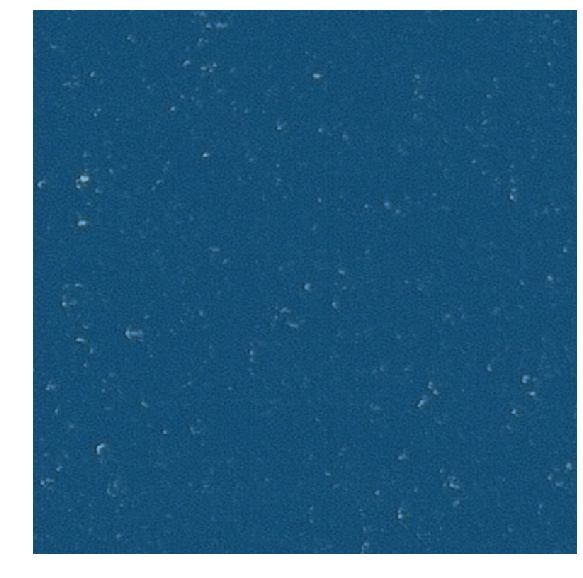

In [18]:
img_f = fnames[-4]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [19]:

src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[768 768]


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

## Data - load w/ datablock api

In [20]:

size = src_size//4
size

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")
bs=4
codes = np.loadtxt(DATA_DIR + 'ship_codes.txt', dtype=str); codes

array(['NotShip', 'Ship'], dtype='<U7')

In [0]:

# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this?
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageImageList):
    _label_cls = SegLabelListCustom

In [0]:

src = (SegItemListCustom.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))


In [0]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

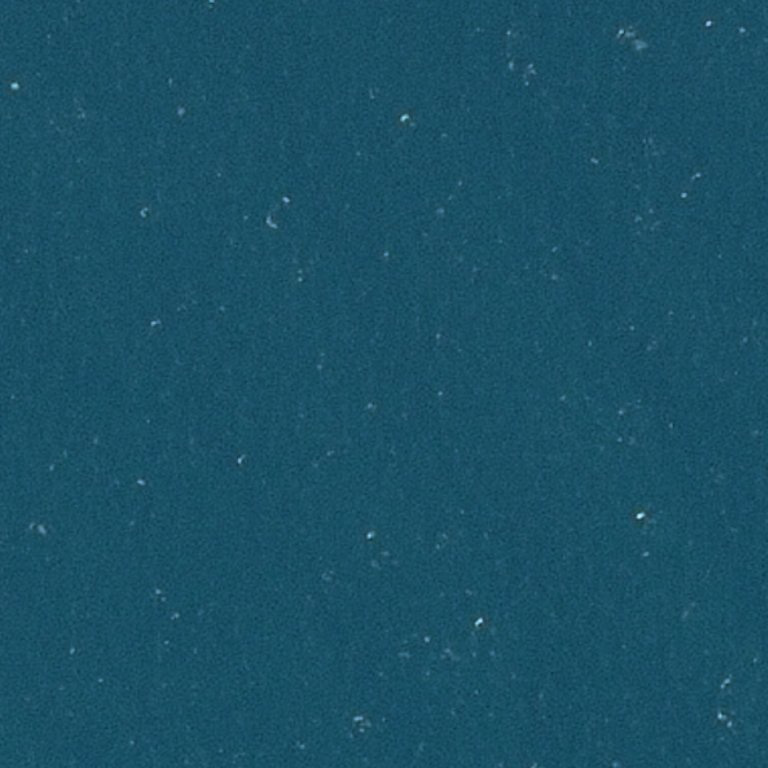

In [24]:
data
data.train_ds.x[1]


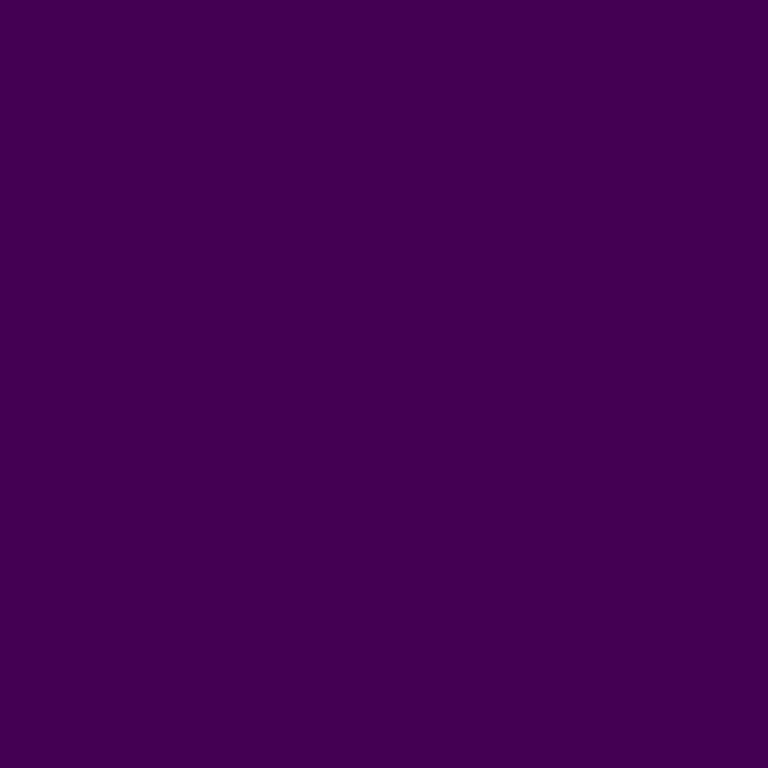

In [25]:
data.train_ds.y[1]


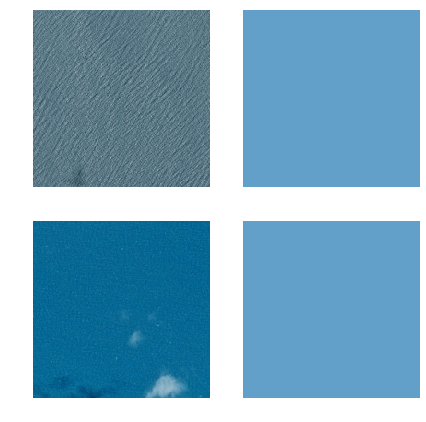

In [26]:
data.show_batch(2,figsize=(6,6), alpha=0.7)


In [27]:
data.classes


array(['NotShip', 'Ship'], dtype='<U7')

## Create Learner

In [0]:
import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)
  

def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()
  
metrics = [dice_loss, accuracy_thresh, dice]

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 92745758.16it/s]


In [0]:
learn.loss_func = combo_loss

learn.loss_func, learn.metrics

In [0]:
print( gpu_mem_get() )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


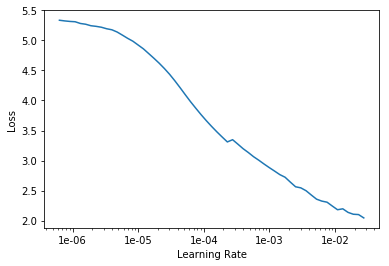

In [0]:
learn.lr_find()
learn.recorder.plot()


In [0]:
lr = 1e-3

In [0]:
learn.fit_one_cycle(3, max_lr=lr)

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.687624,0.694194,0.660569,0.998357,0.333333,00:54
1,0.631608,0.673324,0.660625,0.998357,0.333333,00:50
2,0.528678,0.666919,0.660587,0.998357,0.340199,00:50


In [0]:
learn.save('stage-1')

In [30]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (466 items)
x: SegItemListCustom
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: SegLabelListCustom
ImageSegment (1, 192, 192),ImageSegment (1, 192, 192),ImageSegment (1, 192, 192),ImageSegment (1, 192, 192),ImageSegment (1, 192, 192)
Path: /content/gdrive/My Drive/Colab Notebooks/ships/Train;

Valid: LabelList (30 items)
x: SegItemListCustom
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: SegLabelListCustom
ImageSegment (1, 192, 192),ImageSegment (1, 192, 192),ImageSegment (1, 192, 192),ImageSegment (1, 192, 192),ImageSegment (1, 192, 192)
Path: /content/gdrive/My Drive/Colab Notebooks/ships/Train;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [0]:
learn.show_results(rows=4, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(3, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.590468,0.666054,0.660570,0.998357,0.333638,00:55
1,0.609032,0.671283,0.660569,0.998357,0.333333,00:55
2,0.535680,0.665831,0.660569,0.998357,0.335593,00:55


In [0]:
learn.save('stage-2');

In [0]:
learn.load('stage-2');

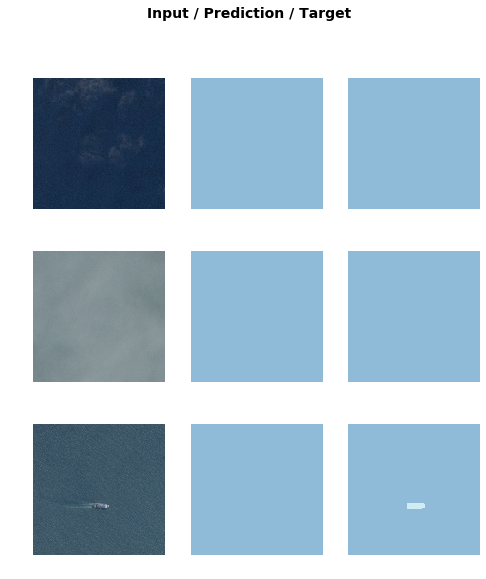

In [31]:
learn.show_results(rows=3, figsize=(8,9))

In [32]:
print( gpu_mem_get() )

GPUMemory(total=11441, free=10097, used=1343)


## Quick load for inference

In [0]:
type(learn.model), type(learn)

(fastai.vision.models.unet.DynamicUnet, fastai.basic_train.Learner)

In [0]:
test = ImageList.from_folder(path_test)
test_names = os.listdir(path_test)

In [42]:
test_names[:5]

['094cdb64d.jpg',
 '0959a858c.jpg',
 '095c10a2f.jpg',
 '096708a44.jpg',
 '09674a357.jpg']

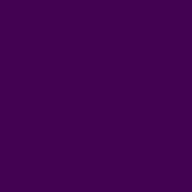

In [38]:
#img = data.test_ds[0][0]
doop = learn.predict(test[0]);
doop[0]

In [0]:
d = {}
for i in range(len(test)):
  test_img = test[i]
  pred_mask = learn.predict(test_img)
  d[ test_names[i] ] = rle_encode( pred_mask[0].data )
  

In [0]:
#pred_df = pd.DataFrame.from_dict(d, orient='index')
pred_df.to_csv('pred.csv')

files.download('pred.csv')

In [58]:
!ls gdrive/'My Drive'/'Colab Notebooks'

'Copy of data_block.ipynb'	        Kangaroo-Wallaby-lesson2.ipynb
'Copy of lesson1-pets.ipynb'	        MinimizeFunctionSciPy.ipynb
'Copy of lesson5-sgd-mnist.ipynb'       PyTorchLearning
'Copy of lesson7-human-numbers.ipynb'   Seal-Count-Dots.ipynb
'Copy of lesson7-resnet-mnist.ipynb'    Seal-Count-Regression.ipynb
'Copy of TweetLM.ipynb'		        ships
 Democrats-Republicans.ipynb	        ships_tanz_mount_gdrive.ipynb
 Digits.ipynb			       'Style Transfer Project Notes.gdoc'
 faces				        TweetLanguageModel.ipynb
 FeatureLoss			        tweets
 hymenoptera			        whale-categorization.ipynb
'Kaggle API with Colab - Setup Guide'   WhaleSpecies.ipynb


## Go Big

In [0]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 8063MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


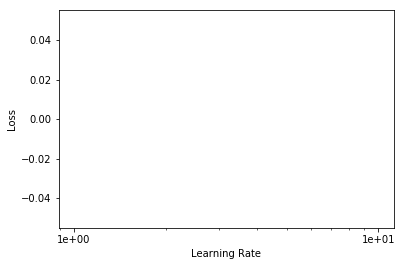

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## Inference

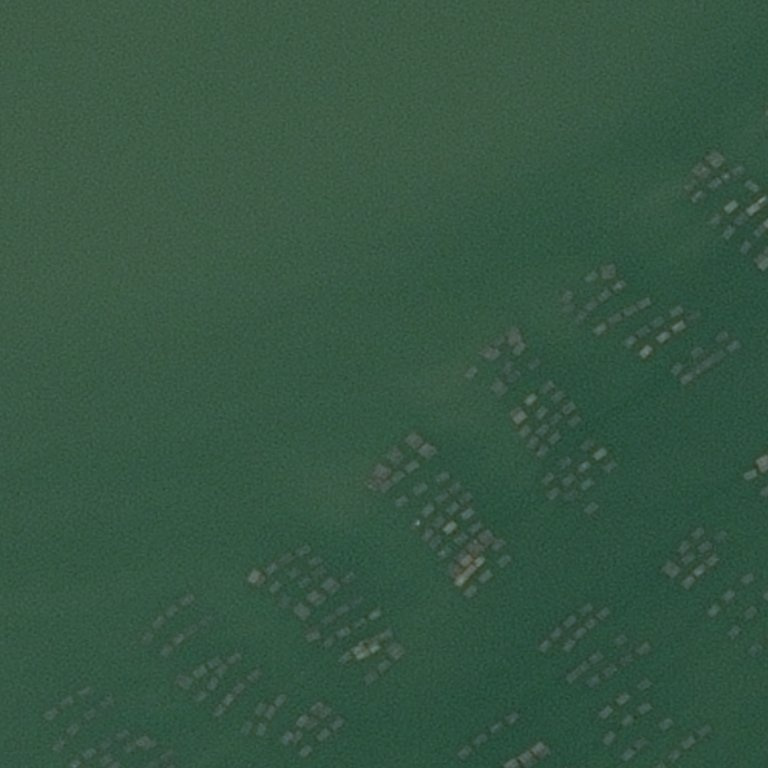

In [0]:
test = ImageList.from_folder(path_test ) 
len(test)
test[2]

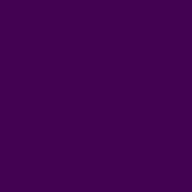

In [0]:
a_test_pred = learn.predict(test[2])
type(a_test_pred[0]), type(a_test_pred[1]) 
a_test_pred[0]

## fin